# コンテンツ
1. LLMとはなにか
2. トークン(LLMのインプット)
3. ボディとヘッドの区別
4. テキスト生成のからくりとテクニック
5. まとめ
6. 今後の進路

# LLMとはなにか
定義を知るよりもコードを試してみたほうがはやい!

In [ ]:
import torch
from transformers import AutoModel

model_ckpt = "gpt2-xl"
# model_ckpt = "distilbert-base-uncased"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)
# bert = AutoModel.from_pretrained(bert_ckpt).to(device)
# 事前学習済みモデルをhugging faceからダウンロードし、
# メモリ上にモデルインスタンスを初期化している
# to(device)のくだりは時間があれば後ほど解説
# 実行するのがCPUかGPUかによってメモリ配置が異なるということ

gpt2 = model
# bert = model

In [ ]:
# __call__methodを調べてみる
print(hasattr(gpt2, '__call__'))
print(getattr(gpt2, '__call__'))
# print(getattr(gpt2, 'forward'))

In [ ]:
# パラメータを調べる
state_dict = gpt2.state_dict()
print(len(state_dict))
for k,v in state_dict.items():
    print("key  :", k)
    print("value:", v.shape)

In [ ]:
# パラメータの総数をかぞえる
n_params = 0
for v in state_dict.values():
    prod = 1
    for d in v.shape:
        prod *= d
    n_params += prod
print("n_params: ", n_params)

## LLMについて何が言えるか？
- LLMは大量のパラメータで特徴づけられたひとつのクラスオブジェクト
- ckpt(チェックポイント): モデルパラメータのひとつの状態
- チェックポイントが同じ<=>全てのパラメータの値が同一であるということが保証されている
- AutoModelクラスを用いて特定の言語モデルの特定のチェックポイントをダウンロードして、モデルクラスとしてロードすることができる
- `__call__()メソッドがこのオブジェクトの実態

それではこの関数のインプットとアウトプットは一体どうなっているのか？

In [ ]:
input_text = "I can't forget you, for"
output = gpt2(input_text)
# output = gpt2.forward(input_text)
# どうやらなんかちがうっぽい

# トークン
- モデルの入力には文字列を直接つっこんではいけない
- 入力文字列はモデルが解釈できるようにトークンに変換する必要があり
- トークンとは一意の整数のこと

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
# 引数の言語モデルに合致するトークナイザを自動的にダウンロードしてロード
input_tokens = tokenizer(input_text)
print(input_tokens)
print(tokenizer.convert_ids_to_tokens(input_tokens.input_ids))
# 文章をトークンに分割してトークン列に変換している

- [BPE tokenizers and spaces before words](https://discuss.huggingface.co/t/bpe-tokenizers-and-spaces-before-words/475)

## 疑問
<span style="color: red; ">コーパス存在しない英単語(uouのようなタイプミス)をトークナイザに入力したとき、エラーが生じてしまったが、chatGPTなどはタイプミスをどのように処理しているのだろうか？事前に処理しているのか？</span>

In [ ]:
tokens = tokenizer(input_text)
tokens_pt = tokenizer(input_text, return_tensors="pt")
tokens_tf = tokenizer(input_text, return_tensors="tf")
print(tokens)
print(tokens_pt)
print(tokens_tf)
# pytorchで処理する用とtensorflowで処理するときにデータの形式が異なる・トークンの値はおなじ
# ちなみに上記のmodelはpytorchを前提としている

In [ ]:
input_tensor = tokenizer(input_text, return_tensors="pt")["input_ids"].to(device)

print("input_text        :", input_text)
print("input_tensor      :", input_tensor)
print("input_tensor size :", input_tensor.shape)

In [ ]:
with torch.no_grad():
    output = gpt2(input_tensor)   #内部で__call__()が呼ばれている
    # output = gpt2.forward(tensor)
    print(output)
    print(output.last_hidden_state.shape)

- どうやらgpt2のアウトプットは隠れ層のテンソルが返っているっぽい
- ここで7というのはトークンの数、1600というのは１つのトークンの次元数

## ここでひとつの疑問
### gpt2は決定的モデルなのか？それとも確率的モデルなのか？
つまり同じ入力を入れると、いつでも必ず同じ出力が生成されるのか、それとも実装内部に乱数生成的な要素が存在しているのか？

実験してみる。

In [ ]:
hidden_state = gpt2(input_tensor).last_hidden_state
print(all([torch.equal(hidden_state, gpt2(input_tensor).last_hidden_state) for _ in range(10)]))
# Trueなら決定論的なモデル

# BodyとHead
- トランスフォーマーにはボディとヘッドという区別がある
- ボディは汎用的な機能を担う
- 専門的なタスクを行いたいときはボディの最後にヘッドをとりつける
- 専門的なタスクの例：テキスト分類、翻訳、要約、次の単語予測
- 行うタスクによってヘッドの種類が変わる・ボディは変わらない

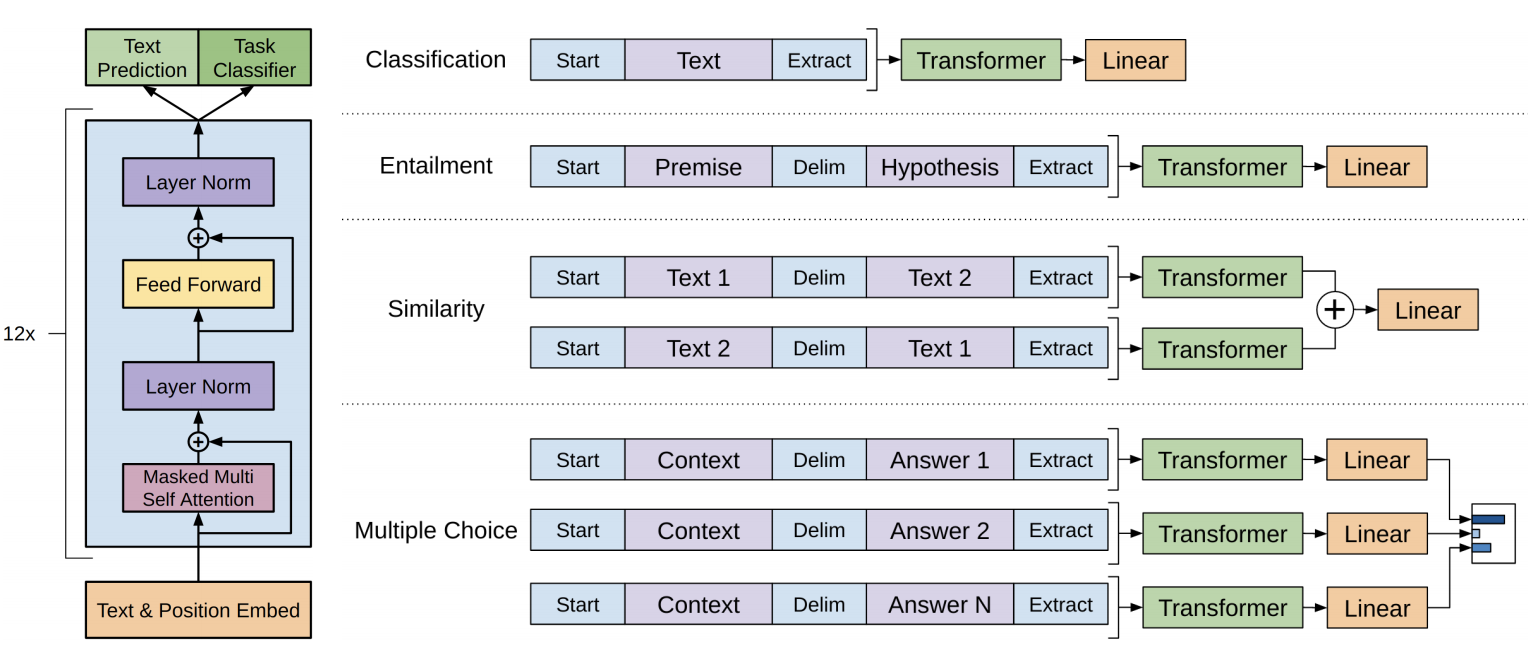


ここで実際のgpt2実装を見てみることにする。

- [OpenAI実装(tensorflow)](https://github.com/openai/gpt-2/blob/master/src/model.py)
- [huggingface実装(torch)](https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py)

### githubでソースをあさるときのコツ
ファイルが新規生成されたコミットまでさかのぼる!

```bash
git log --diff-filter=A --follow ./src/transformers/models/gpt2/modeling_gpt2.py
```

実装された瞬間のソースはバグなどが含まれている可能性が高い反面、余計なものが削ぎ落されていて意図を読み取りやすいため、可読性がとても高い。学習ソースとして優れている。

# テキスト生成のからくり
GPT-2の最大の売り、テキスト生成はどういう仕組みなのか？

まずはコードを見てみる

In [ ]:
from transformers import AutoModelForCausalLM

gpt2 = AutoModelForCausalLM.from_pretrained(model_ckpt).to(device)

- AutoModeForCausalLMという先ほどとは少し異なるクラスのオブジェクトがロードされている。
- これの正体はGPT-2のボディにLMHEADを乗せたもの。
- つまりボディの出力をHEADに入力して出力させている。

In [ ]:
with torch.no_grad():
    output = gpt2(input_tensor)
    print(output)
    # print(output.logits.shape)
    logits = output.logits[0,-1,:]
    
    next_token_probs = torch.softmax(logits, dim=-1)
    print("next_token_probs :", next_token_probs)
    

- logitsは3次元テンソル(1次元目はバッチ数、2次元目はトークン数をあらわす、3次元目はコーパスに登録されているトークンの総数)
- 求めたいのは最初のバッチの最後のトークンがもつ実数のベクトル(50257次元)
- これはコーパスに存在するトークンの総数に相当する
- つまり最後のトークンにロジット(実数)が50257個わりあてられていることになる
- これをソフトマックスに通すことで最後のトークンの次に来るであろうトークンの生成分布が計算される

In [ ]:
# 次のトークン確率が最も高いものをアウトプットとして選ぶ
# それをインプットに追加する
# 次のトークン確率が最も高いものをアウトプットとして選ぶ
# それをインプットに追加する
# n回繰り返し

n = 20
prev_token_ids = torch.Tensor.detach(input_tensor)

with torch.no_grad():
    for _ in range(n):
        
        output = gpt2(prev_token_ids)
        next_token_logits = output.logits[0,-1,:]
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
        next_token_id = sorted_ids[0]
        prev_token_ids = torch.cat([prev_token_ids, sorted_ids[None, 0, None]], dim=-1)
for token in prev_token_ids:
    print(tokenizer.decode(token))

## ビームサーチ
- $P(X_k|X_1,X_2,,,,X_{k-1})$が最大になるような$X_k$を自動的に選んでいくだけでは面白みがない
- たとえそんなに大きくない$P(X_k|X_1,X_2,,,X_{k-1})$をもつ$X_k$を選んだとしても、n個のトークンを生成し終えたときに同時確率$P(X_1,X_2,,,,,,X_n)$の値が大きければ自然な文章が生成されているはず
- この発想により、最大の$P(X_k|X_1,X_2,,,,X_{k-1})$になる$X_k$を選ぶことを留保して、トークンを生成する際に、同時確率$P(X_1,X_2,,,,,,X_k)$の中から大きいものをいくつかあたりをつけておくテクニックをビームサーチとよぶ

In [ ]:
output_beam = gpt2.generate(input_tensor, max_length=100, num_beams=5)
print(tokenizer.decode(output_beam[0]))

## サンプリング
- これまでの手法はすべて決定論的で、生成系AIとしてはまだ面白みがない。
- アウトプットに幅を持たせるためには、最後の生成分布からランダムサンプリングする必要がある。

### 温度パラメータ
- 単純にランダムサンプリングするのではなく、温度パラメータ$T$を付加することで、分布を変形させることができる。

$P(y_t = w_i|y_1,y_2,,,y_{t-1}) = \frac{\exp(Z_{t,i}/T)}{\sum_{j=1}^{V}{\exp(z_{t,j}/T)}}$

- Tが1のときはランダムサンプリングと同じ
- Tが1より小さいと、確率の大きなトークンはより選ばれやすくなる
→退屈な文章になりやすい
- Tが1より大きいと、確率の小さなトークンも選ばれやすくなる
→カオスな文章になりやすい

### Top-Kサンプリング
次の生成確率が大きい順にトークンを並べたときに、上位ｋ個の中からランダムにサンプリングする手法。

In [ ]:
# 温度をいじってトークンの確率分布を変えることで生成される文章が変わる
output_temp_small = gpt2.generate(input_tensor, max_length=100, do_sample=True,\
                                  temperature=0.5)
output_temp_large = gpt2.generate(input_tensor, max_length=100, do_sample=True,\
                                  temperature=2.0)
print(tokenizer.decode(output_temp_small[0]))
print(tokenizer.decode(output_temp_large[0]))

In [ ]:
# top_kサンプリング
output_topk = gpt2.generate(input_tensor, max_length=100, do_sample=True, top_k=50)
print(tokenizer.decode(output_topk[0]))

# まとめ
LLMのひとつであるGPT2の中身を概観しました。これで参加者間の前提知識が共有できればありがたいです。もっと専門的なことを知りたかった方、申し訳ありませんでした。次は自分ももっと掘り下げたものが共有できるようにいたします。たとえば、

- bertの実装(gpt系との比較において)
- RLHF(Reinforcement Learning Human Feedback)
- 並行処理(parallel)の実際

などのトピックは用意があります。

# 参考文献・URL
- [scikit-learnとTensorFlowによる実践機械学習](https://www.amazon.co.jp/dp/4873118344)
    - 新しい版が出てるのでそちらを買ったほうがいいかも
    - 新しい版ではkerasを導入していてコードの可読性が上がっている
- [機械学習エンジニアのためのTransformers](https://www.amazon.co.jp/dp/4873119952)
    - おもに5章のテキスト生成パート
- [OpenAI実装(tensorflow)](https://github.com/openai/gpt-2/blob/master/src/model.py)
- [huggingface実装(torch)](https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py)
- [いちgoogle社員の見解](https://www.semianalysis.com/p/google-we-have-no-moat-and-neither)
- [LLM WorkSheet](https://docs.google.com/spreadsheets/d/1kT4or6b0Fedd-W_jMwYpb63e1ZR3aePczz3zlbJW-Y4)
- [LoRA(Low Rank Adaptation)](https://arxiv.org/pdf/2106.09685)
